![Olist](Olist_pics/logo-olist.png)

# Seller Segmentation based on Sale/NoSale 

Seller Segmentation based on Sale/NoSale. What does it take to sell? 
    
 01. Random Forest Regressor model that predicts 1-month avg LTV
 02. Feature Importances

In [1]:
#Importing Libraries & set up
import byMontse as byM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import datetime,date,timedelta 
import datetime as dt
import calendar

#NLP
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from wordcloud import WordCloud, STOPWORDS

#ML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier, plot_tree
from sklearn import tree

#Image and options
import graphviz
from graphviz import Source
from IPython.display import Image
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)

# Configure visualizations
%matplotlib inline
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'grid.linestyle': '--','figure.figsize': [12, 10], 'font.size': 16}
sns.set_theme(style='ticks', rc=custom_params)
base_color=sns.color_palette()[0]

#Warnings managemnet
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
seller=pd.read_csv('Olist_saved/seller_df.csv')
byM.datasummary(seller).fillna('')

Dataset Shape: (765, 32)


,dtypes,count,unique,missing,top,freq,mean,std,min,25%,50%,75%,max,First Value
seller_id,object,765.0,765,0,a11a0e0ca67423425691db355cff69b0,1,,,,,,,,2c43fb513632d29b3b58df74816f1b06
sdr_id,object,765.0,22,0,4b339f9567d060bcea4f5136b9f5949e,137,,,,,,,,a8387c01a09e99ce014107505b92388c
sr_id,object,765.0,18,0,4ef15afb4b2723d8f3d81e51ec7afefe,130,,,,,,,,4ef15afb4b2723d8f3d81e51ec7afefe
won_date,object,765.0,146,0,2018-04-30,22,,,,,,,,2018-02-26
business_segment,object,765.0,32,0,home_decor,96,,,,,,,,pet
lead_type,object,765.0,8,0,online_medium,303,,,,,,,,online_medium
lead_behaviour_profile,object,765.0,8,0,cat,373,,,,,,,,cat
business_type,object,765.0,3,0,reseller,529,,,,,,,,reseller
first_contact_date,object,765.0,180,0,2018-02-06,13,,,,,,,,2018-02-21
landing_page_id,object,765.0,122,0,b76ef37428e6799c421989521c0e5077,163,,,,,,,,b48ec5f3b04e9068441002a19df93c6c


In [3]:
#variable selection. Rest of variables are indicative of output (i.e.product_unique)
df=seller[['won_month','business_segment','lead_type','lead_behaviour_profile','business_type','contact_month','seller_acquisition_days','origin','seller_days_withOlist','total_sold']]
df['target'] = [1 if row > 0 else 0 for row in df['total_sold']]

<ipython-input-3-f1640b8228ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = [1 if row > 0 else 0 for row in df['total_sold']]


In [4]:
X=df.drop(columns=['target','total_sold'])
X=pd.get_dummies(X, drop_first=True)
y=df['target']

In [5]:
print(X.shape,y.shape)

(765, 61) (765,)


### Random Forest Classifier

I picked a **random forest classifier** to predict sale/no sale. Main reasons: 
- it usually requires very little time to optimize it (its default params are often close to be the best ones) 
- it is strong with outliers, irrelevant variables, continuous and discrete variables.
- overcomes the problem of overfitting by averaging or combining the results of different decision trees.
I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. 

In [6]:
#split into train and test to avoid overfitting
SEED=123 #reproductility
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.30, random_state=SEED)

# define the model
rfc = RandomForestClassifier(random_state=SEED, n_estimators=50, max_depth=4, oob_score=True)

#fit the model & predict
rfc.fit(X_train, y_train)
predictions= rfc.predict(X_test)

#and let's print OOB confusion matrix
print('OOB Confusion matrix')
conf_matrix_train = pd.DataFrame(confusion_matrix(y_train, rfc.oob_decision_function_[:,1].round(), labels=[0, 1]))
print(conf_matrix_train)
#and let's print test set confusion matrix
print('Test set Confusion matrix')
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predictions, labels=[0, 1]))
print(conf_matrix)

OOB Confusion matrix
     0    1
0  179   97
1  121  138
Test set Confusion matrix
    0   1
0  60  49
1  53  68


In [7]:
#let's print model accuracy and class errors
class0_error_train = 1 - conf_matrix_train.loc[0,0]/(conf_matrix_train.loc[0,0]+conf_matrix_train.loc[0,1])
class1_error_train = 1 - conf_matrix_train.loc[1,1]/(conf_matrix_train.loc[1,0]+conf_matrix_train.loc[1,1])
print('OOB:')  
print(pd.DataFrame( {'oob_score': rfc.oob_score_,
                         'class0_error' :[class0_error_train],
                         'class1_error' :[class1_error_train]
}))

#let's print model accuracy and class errors
class0_error = 1 - conf_matrix.loc[0,0]/(conf_matrix.loc[0,0]+conf_matrix.loc[0,1])
class1_error = 1 - conf_matrix.loc[1,1]/(conf_matrix.loc[1,0]+conf_matrix.loc[1,1])
print('\nTEST:')   
print(pd.DataFrame( {'accuracy': rfc.score(X_test,y_test),
                         'class0_error' :[class0_error],
                         'class1_error' :[class1_error]
}))

OOB:
   oob_score  class0_error  class1_error
0       0.59          0.35          0.47

TEST:
   accuracy  class0_error  class1_error
0      0.56          0.45          0.44


In [8]:
rf=RandomForestClassifier(random_state=SEED, oob_score=True)
params_rfc = {'n_estimators':[50,100,350,500],
                'max_features':['log2','auto','sqrt'],
                'min_samples_leaf':[5,10,20,30]}



# Instantiate grid_rf
grid_rfc = GridSearchCV(estimator=rf,
                       param_grid=params_rfc,
                       scoring='accuracy',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

grid_rfc.fit(X_train, y_train)
# Extract the best estimator
best_estimator=grid_rfc.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [9]:
best_estimator

{'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 50}

In [10]:
# define the model
rfc = RandomForestClassifier(random_state=SEED, n_estimators=best_estimator.get('n_estimators'), min_samples_leaf=best_estimator.get('min_samples_leaf'),max_features=best_estimator.get('max_features'),oob_score=True)

#fit the model & predict
rfc.fit(X_train, y_train)
predictions= rfc.predict(X_test)

#and let's print OOB confusion matrix
print('OOB Confusion matrix')
conf_matrix_oob = pd.DataFrame(confusion_matrix(y_train, rfc.oob_decision_function_[:,1].round(), labels=[0, 1]))
print(conf_matrix_oob)
#and let's print test set confusion matrix
print('Test set Confusion matrix')
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predictions, labels=[0, 1]))
print(conf_matrix)

OOB Confusion matrix
     0    1
0  181   95
1  113  146
Test set Confusion matrix
    0   1
0  64  45
1  55  66


In [11]:
#let's print model accuracy and class errors
class0_error_oob = 1 - conf_matrix_oob.loc[0,0]/(conf_matrix_oob.loc[0,0]+conf_matrix_oob.loc[0,1])
class1_error_oob = 1 - conf_matrix_oob.loc[1,1]/(conf_matrix_oob.loc[1,0]+conf_matrix_oob.loc[1,1])
print('train errors:')  
print(pd.DataFrame( {'oob_score': rfc.oob_score_,
                         'class0_error' :[class0_error_oob],
                         'class1_error' :[class1_error_oob]
}))

#let's print model accuracy and class errors
class0_error = 1 - conf_matrix.loc[0,0]/(conf_matrix.loc[0,0]+conf_matrix.loc[0,1])
class1_error = 1 - conf_matrix.loc[1,1]/(conf_matrix.loc[1,0]+conf_matrix.loc[1,1])
print('\ntest errors:')   
print(pd.DataFrame( {'accuracy': rfc.score(X_test,y_test),
                         'class0_error' :[class0_error],
                         'class1_error' :[class1_error]
}))

train errors:
   oob_score  class0_error  class1_error
0       0.61          0.34          0.44

test errors:
   accuracy  class0_error  class1_error
0      0.57          0.41          0.45


#### Observations:
OOB and test error are very similar, so we are confident we are not overfitting. 
We have an initial probability to predict sale/no sale of 50% (just because of target distribution). The model accuracy is 60%, a 20% increase, not much.

### Features Importances

In [12]:
#Reference levels for the categorical variables
data_categorical = df.select_dtypes(['object']).astype("category") 
#find reference level, i.e. the first level
print(data_categorical.apply(lambda x: x.cat.categories[0]))

business_segment          air_conditioning
lead_type                         industry
lead_behaviour_profile                 cat
business_type                 manufacturer
origin                      direct_traffic
dtype: object


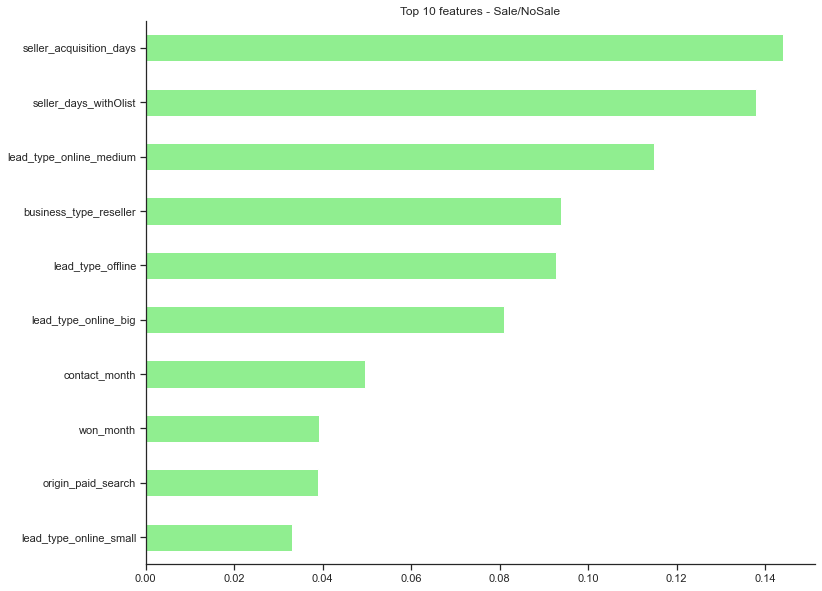

<Figure size 864x720 with 0 Axes>

In [13]:
# Create a pd.Series of features importances
importances_rfc = pd.Series(rfc.feature_importances_, index = X.columns)
# Sort importances_rf                                   
sorted_importances_rfc = importances_rfc.nlargest(10)  
#print(sorted_importances_rfc)
# Make a horizontal bar plot
sorted_importances_rfc.sort_values(ascending=True).plot(kind='barh', color='lightgreen') 
plt.title('Top 10 features - Sale/NoSale')
plt.show()
plt.savefig('Olist_saved/Top10features.png')

RF feature importances have a bias toward numerical variables, this is the main reason why the 2 top features are numerical. In general, the overall impact of a categorical variable gets penalized here since we are looking at each dummy variable independently. For a similar reason, the dummy variables from categorical variables with less levels, like business_type, show up as more important (its overall importance is split into less dummy variables).

Anyway I'll focus to extract insights from the regression model.